In [1]:
import os
import os.path
import json
import numpy as np
import sys
import importlib
import tensorflow as tf
import string
import re
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = '/home/kalugin/Documents/experiments/pointnet-autoencoder'

In [3]:
ROOT_DIR = BASE_DIR
sys.path.append(BASE_DIR) # model
sys.path.append(ROOT_DIR) # provider
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))

In [4]:
MODEL = importlib.import_module('model')

In [5]:
DATA_PATH = os.path.join(BASE_DIR, 'data/shapenetcore_partanno_segmentation_benchmark_v0')

In [6]:
sys.path.append(os.path.join('./', 'utils'))

In [7]:
import show3d_balls
import tf_util

In [8]:
root = './data/shapenetcore_partanno_segmentation_benchmark_v0/'

In [9]:
with open(os.path.join(root, 'train_test_split', 'shuffled_test_file_list.json'), 'r') as f:
    test_ids = set([str(d.split('/')[2]) for d in json.load(f)])

In [10]:
catfile = os.path.join(root, 'synsetoffset2category.txt')

In [11]:
cat = {}

In [12]:
with open(catfile, 'r') as f:
    for line in f:
        ls = line.strip().split()
        cat[ls[0]] = ls[1]

In [13]:
item = 'Chair'

In [14]:
dir_point = os.path.join(root, cat[item], 'points')
dir_seg = os.path.join(root, cat[item], 'points_label')
fns = sorted(os.listdir(dir_point))
fns = [fn for fn in fns if fn[0:-4] in test_ids]

In [15]:
meta_chair = []

In [16]:
for fn in fns:
    token = (os.path.splitext(os.path.basename(fn))[0]) 
    meta_chair.append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg')))

In [36]:
len(meta_chair)

704

In [17]:
points = [np.loadtxt(i[0]) for i in meta_chair[:1000]]

In [18]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [19]:
GPU_INDEX = 0

In [20]:
def get_model(MODEL_PATH, batch_size=1, num_point=2048):
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            
            embedding = tf.placeholder(tf.float32, shape=(1, 1024))
            net = tf_util.fully_connected(embedding, 1024, bn=True, is_training=False, scope='fc1', bn_decay=None)
            net = tf_util.fully_connected(net, 1024, bn=True, is_training=False, scope='fc2', bn_decay=None)
            net = tf_util.fully_connected(net, num_point*3, activation_fn=None, scope='fc3')
            net = tf.reshape(net, (batch_size, num_point, 3))
            
            saver = tf.train.Saver()
        # Create a session
        print(net)
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'embedding': embedding,
               'pred': pred,
               'loss': loss}
        return sess, ops, net

In [21]:
normal_sess, normal_ops, normal_decoder = get_model('./log_chair_norotation/model_4.ckpt')




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Tensor("Reshape_2:0", shape=(1, 2048, 3), dtype=float32, device=/device:GPU:0)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./log_chair_norotation/model_4.ckpt


In [22]:
noised_sess, noised_ops, noised_decoder = get_model('./log_chair_norotation/noised_model_2_rate_10_std_0.05.ckpt')

Tensor("Reshape_2:0", shape=(1, 2048, 3), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from ./log_chair_norotation/noised_model_2_rate_10_std_0.05.ckpt


In [23]:
normal_ops

{'embedding': <tf.Tensor 'Placeholder_3:0' shape=(1, 1024) dtype=float32>,
 'is_training_pl': <tf.Tensor 'Placeholder_2:0' shape=() dtype=bool>,
 'labels_pl': <tf.Tensor 'Placeholder_1:0' shape=(1, 2048, 3) dtype=float32>,
 'loss': (<tf.Tensor 'mul:0' shape=() dtype=float32>,
  {'embedding': <tf.Tensor 'Reshape:0' shape=(1, 1024) dtype=float32>,
   'pcloss': <tf.Tensor 'Mean:0' shape=() dtype=float32>}),
 'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 2048, 3) dtype=float32>,
 'pred': <tf.Tensor 'Reshape_1:0' shape=(1, 2048, 3) dtype=float32>}

In [24]:
pc = points[25][:2048]

In [25]:
from scipy.spatial.transform import Rotation as R

In [26]:
angles = np.arange(0, 181, 45)

In [27]:
angles

array([  0,  45,  90, 135, 180])

In [28]:
rotated_pc = {}
for i in angles:
    for j in angles:
        for k in angles:
            r = R.from_euler('xyz', [i, j, j], degrees=True)
            rotated_pc[(i, j, k)] = r.apply(pc)

In [29]:
rotated_pc.keys()[:20]

[(0, 180, 135),
 (0, 0, 45),
 (90, 180, 90),
 (180, 135, 0),
 (180, 0, 90),
 (180, 90, 90),
 (45, 0, 0),
 (180, 180, 90),
 (45, 135, 180),
 (135, 135, 180),
 (0, 0, 135),
 (135, 90, 90),
 (90, 90, 135),
 (90, 135, 180),
 (180, 90, 45),
 (135, 90, 135),
 (135, 45, 135),
 (0, 90, 135),
 (135, 180, 90),
 (90, 135, 0)]

In [30]:
limits = []
for pc in rotated_pc.values():
    limits.append(pc.max())
    limits.append(pc.min())

In [31]:
max(limits), min(limits)

(0.4885586338436108, -0.4730755648510844)

In [32]:
len(rotated_pc.keys())

125

In [33]:
rotated_embeddings = {}
rotated_reconstructions = {}
for angles, pc in rotated_pc.items():
    embedding, reconstruction = normal_sess.run([normal_ops['loss'][1]['embedding'], normal_ops['pred']], feed_dict=
                             {normal_ops['pointclouds_pl']: np.expand_dims(pc, axis=0),
                              normal_ops['is_training_pl']: False})
    rotated_embeddings[angles] = embedding
    rotated_reconstructions[angles] = reconstruction

In [34]:
rotated_reconstructions[(0, 0, 0)][0].shape

(2048, 3)

In [234]:
show3d_balls.showpoints(rotated_pc[(0,0,0)], ballradius=4)

KeyboardInterrupt: 

## EVEN NOT NOISED MODEL CAN NOT RECONSTRUCT ROTATED OBJECT

In [243]:
show3d_balls.showpoints(np.random.permutation(pc), ballradius=4)

KeyboardInterrupt: 

In [240]:
np.random.permutation(rotated_pc[(0,0,0)])

AttributeError: 'module' object has no attribute 'permutation'

In [248]:
base_embedding, base_reconstruction = normal_sess.run([normal_ops['loss'][1]['embedding'], normal_ops['pred']], feed_dict=
                             {normal_ops['pointclouds_pl']: np.expand_dims(rotated_pc[(0,0,0)] + 0.02, axis=0),
                              normal_ops['is_training_pl']: False})
show3d_balls.showpoints(base_reconstruction[0], ballradius=4)

KeyboardInterrupt: 

In [237]:
show3d_balls.showpoints(rotated_reconstructions[(0,0,0)][0], ballradius=4)

KeyboardInterrupt: 

In [208]:
base_embedding, base_reconstruction = normal_sess.run([normal_ops['loss'][1]['embedding'], normal_ops['pred']], feed_dict=
                             {normal_ops['pointclouds_pl']: np.expand_dims(points[25][:2048], axis=0),
                              normal_ops['is_training_pl']: False})
show3d_balls.showpoints(base_reconstruction[0], ballradius=4)

KeyboardInterrupt: 

## IDEAS TO ADD NOISE:

## NULLIFY SOME RANDOM POINTS 

## ADD UNIFORME NOISE ALL OVER THE SPACE

## NULLIFY SOME LITTLE PART OF THE OBJECT

In [197]:
show3d_balls.showpoints(pc, ballradius=4)

KeyboardInterrupt: 

In [198]:
show3d_balls.showpoints(rotated_reconstructions[(0, 0, 0)][0], ballradius=4)

KeyboardInterrupt: 

In [72]:
rotated_embeddings = np.array([i[0] for i in rotated_embeddings)

In [73]:
angle_between(rotated_embeddings[0], rotated_embeddings[1])

0.3000933

## COUNT NORM OF EMBEDDINGS THROUGH THE DATASET

## MODEL WITH NOISE = 0.1 WORKS VERY BAD

## MODEL WITH NOISE = 0.05 WORKS BAD ALSO

In [91]:
dataset_embeddings = []
dataset_reconstructions = []
for pc in points:
    embedding, reconstruction = normal_sess.run([normal_ops['loss'][1]['embedding'], normal_ops['pred']], feed_dict=
                             {normal_ops['pointclouds_pl']: np.expand_dims(pc[:2048], axis=0),
                              normal_ops['is_training_pl']: False})
    dataset_embeddings.append(embedding)
    dataset_reconstructions.append(reconstruction)

In [128]:
dataset_embeddings[0][0].shape

(1024,)

(array([ 17., 105., 165., 202., 166., 106.,  68.,  58.,  43.,  22.,  19.,
         12.,  10.,  10.,  10.,   5.,   3.,   2.,   0.,   1.]),
 array([0.43223712, 0.7851825 , 1.1381278 , 1.4910731 , 1.8440186 ,
        2.1969638 , 2.5499094 , 2.9028547 , 3.2558    , 3.6087453 ,
        3.9616907 , 4.314636  , 4.6675816 , 5.020527  , 5.373472  ,
        5.7264175 , 6.079363  , 6.432308  , 6.7852535 , 7.138199  ,
        7.491144  ], dtype=float32),
 <a list of 20 Patch objects>)

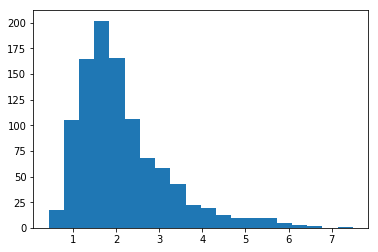

In [127]:
plt.hist(dataset_embeddings[0][0], bins=20)

In [92]:
emb_norms = np.array([np.linalg.norm(i) for i in dataset_embeddings])

(array([  1.,   1.,   0.,   0.,   2.,   3.,   3.,   2.,  10.,   9.,  19.,
         39.,  64., 117., 117., 134., 121.,  40.,  20.,   2.]),
 array([54.404823, 55.78607 , 57.167324, 58.548576, 59.929825, 61.311073,
        62.692326, 64.07358 , 65.45483 , 66.836075, 68.21733 , 69.59858 ,
        70.97983 , 72.36108 , 73.742325, 75.12358 , 76.50483 , 77.88608 ,
        79.267334, 80.64858 , 82.02983 ], dtype=float32),
 <a list of 20 Patch objects>)

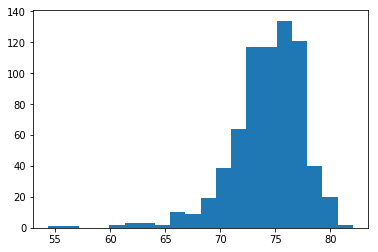

In [152]:
plt.hist(emb_norms, bins=20)

In [249]:
dataset_embeddings.shape

(704, 1, 1024)

In [250]:
from sklearn.manifold import TSNE

ImportError: No module named sklearn.manifold

In [251]:
import sklearn

ImportError: No module named sklearn

In [111]:
np.where(emb_norms < 65)

(array([212, 217, 226, 230, 293, 299, 321, 345, 364, 380, 555, 592]),)

In [118]:
first, second = 270, 293

In [119]:
middle = normal_sess.run(normal_decoder, feed_dict={normal_ops['embedding']: (dataset_embeddings[first] + dataset_embeddings[second]) / 2})

In [ ]:
show3d_balls.showpoints(middle[0], ballradius=4)

two very different and specific objects (rare emb norm), middle value of emb have no sence

In [147]:
noise = np.random.multivariate_normal(2 * np.ones(1024), 1.5 * np.eye(1024))

In [148]:
np.linalg.norm(noise)

76.3820544571572

In [164]:
obj_from_noise = normal_sess.run(normal_decoder, feed_dict={normal_ops['embedding']: np.expand_dims(noise, axis=0)})

In [150]:
show3d_balls.showpoints(obj_from_noise[0], ballradius=4)

KeyboardInterrupt: 

Object created from gaussian noise -- looks like just the simpliest chair

In [157]:
dataset_embeddings = np.array(dataset_embeddings)

In [162]:
dataset_embeddings.mean(axis=0).shape

(1, 1024)

In [165]:
mean_obj = normal_sess.run(normal_decoder, feed_dict={normal_ops['embedding']: dataset_embeddings.mean(axis=0)})

In [ ]:
show3d_balls.showpoints(mean_obj[0], ballradius=4)

In [256]:
mean_obj[0][0] = 0

In [257]:
mean_obj

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.06886346, -0.03349797, -0.00575994],
        [ 0.28923652, -0.15293175, -0.20237601],
        ...,
        [-0.02978737, -0.07387929, -0.09354286],
        [-0.13450755,  0.05299681,  0.00252825],
        [ 0.13116962, -0.04751446, -0.2412029 ]]], dtype=float32)

mean object looks very much alike random object

In [75]:
for i, v in enumerate(rotated_embeddings):
    print(angles[i], np.linalg.norm(v), angle_between(rotated_embeddings[i], rotated_embeddings[i + 1]) if i + 1 < len(angles) else None)

(0.0, 71.81719, 0.3000933)
(22.5, 67.85972, 0.23926947)
(45.0, 67.86036, 0.19990507)
(67.5, 68.785194, 0.21464097)
(90.0, 70.315994, 0.26075718)
(112.5, 72.8224, 0.26063067)
(135.0, 74.270775, 0.23970142)
(157.5, 75.372055, 0.20148765)
(180.0, 77.43076, 0.20187862)
(202.5, 76.1203, 0.26414692)
(225.0, 72.30133, 0.27314028)
(247.5, 67.42528, 0.2748598)
(270.0, 65.859344, 0.27856076)
(292.5, 69.15883, 0.21207146)
(315.0, 74.117004, 0.24882182)
(337.5, 74.94361, 0.25918946)
(360.0, 71.81719, None)


In [167]:
show3d_balls.showpoints(points[100], ballradius=4)

KeyboardInterrupt: 

In [168]:
show3d_balls.showpoints(points[200], ballradius=4)

KeyboardInterrupt: 

In [175]:
show3d_balls.showpoints(dataset_reconstructions[100][0], ballradius=4)

KeyboardInterrupt: 

In [176]:
show3d_balls.showpoints(dataset_reconstructions[200][0], ballradius=4)

KeyboardInterrupt: 

In [177]:
middle_obj = normal_sess.run(normal_decoder, feed_dict={normal_ops['embedding']: (dataset_embeddings[100] + dataset_embeddings[200]) / 2})

In [178]:
show3d_balls.showpoints(middle_obj[0], ballradius=4)

KeyboardInterrupt: 

middle object doesn't show a lot of "middle" propreties

## BETTER TRAINED MODEL NEEDED

In [ ]:
moved = np.expand_dims(np.clip(points[1][:2048, :] + 0.03, -1., 1.), axis=0)

In [37]:
embedding, reconstruction = normal_sess.run([normal_ops['loss'][1]['embedding'], normal_ops['pred']], feed_dict=
                             {normal_ops['pointclouds_pl']: moved,
                              normal_ops['is_training_pl']: False})

In [38]:
pc_reconstruit = normal_sess.run(normal_decoder, feed_dict={normal_ops['embedding']: embedding})

In [49]:
pc_reconstruit[0].shape

(2048, 3)

In [ ]:
show3d_balls.showpoints(points[1][:2048], ballradius=8)

In [31]:
show3d_balls.showpoints(reconstruction[0], ballradius=8)

KeyboardInterrupt: 

In [32]:
show3d_balls.showpoints(pc_reconstruit[0], ballradius=8)

KeyboardInterrupt: 

In [36]:
ph_points = np.expand_dims(points[0][:2048, :], axis=0)

In [36]:
moved = np.expand_dims(np.clip(points[1][:2048, :] + 0.03, -1., 1.), axis=0)

In [62]:
feed_dict = {noised_ops['pointclouds_pl']: np.expand_dims(points[1][:2048, :], axis=0), noised_ops['is_training_pl']: False}

In [40]:
noised_emb = normal_sess.run(normal_ops['loss'][1]['embedding'], feed_dict={normal_ops['pointclouds_pl']: np.expand_dims(points[1][:2048, :], axis=0),
                                                              normal_ops['is_training_pl']: False})

In [38]:
noised_emb = noised_sess.run(noised_ops['loss'][1]['embedding'], feed_dict={noised_ops['pointclouds_pl']: np.expand_dims(points[1][:2048, :], axis=0), 
                                                              noised_ops['labels_pl'] :np.expand_dims(points[1][:2048, :], axis=0),
                                                              noised_ops['is_training_pl']: False})

NameError: name 'noised_sess' is not defined

In [35]:
points[0].mean(axis=0)

array([-0.07849486, -0.02878492,  0.00089697])

In [85]:
emb = noised_emb[1]['embedding']

In [87]:
custom_emb = (0., {'embedding': emb, 'pcloss' : 0.}) 

In [90]:
MODEL.get_model()

<module 'model' from '/home/kalugin/Documents/experiments/pointnet-autoencoder/models/model.pyc'>

In [ ]:


output_labels = noised_sess.run(noised_ops['pred'], feed_dict={noised_ops['is_training_pl']: False, 
                                                               noised_ops['loss'] : custom_emb})

In [59]:
show3d_balls.showpoints(ph_points[0], ballradius=8)

KeyboardInterrupt: 

In [60]:
show3d_balls.showpoints(noised_emb[0][0], ballradius=8)

KeyboardInterrupt: 

In [379]:
batch = np.reshape(np.arange(3*2048*32), newshape=(32, 2048, 3))

In [315]:
batch[:, 0] = 0

In [380]:
batch = batch / 150000. - 0.2

In [381]:
batch

array([[[-0.2       , -0.19999333, -0.19998667],
        [-0.19998   , -0.19997333, -0.19996667],
        [-0.19996   , -0.19995333, -0.19994667],
        ...,
        [-0.1591    , -0.15909333, -0.15908667],
        [-0.15908   , -0.15907333, -0.15906667],
        [-0.15906   , -0.15905333, -0.15904667]],

       [[-0.15904   , -0.15903333, -0.15902667],
        [-0.15902   , -0.15901333, -0.15900667],
        [-0.159     , -0.15899333, -0.15898667],
        ...,
        [-0.11814   , -0.11813333, -0.11812667],
        [-0.11812   , -0.11811333, -0.11810667],
        [-0.1181    , -0.11809333, -0.11808667]],

       [[-0.11808   , -0.11807333, -0.11806667],
        [-0.11806   , -0.11805333, -0.11804667],
        [-0.11804   , -0.11803333, -0.11802667],
        ...,
        [-0.07718   , -0.07717333, -0.07716667],
        [-0.07716   , -0.07715333, -0.07714667],
        [-0.07714   , -0.07713333, -0.07712667]],

       ...,

       [[ 0.98784   ,  0.98784667,  0.98785333],
        [ 0

In [382]:
centers = np.random.uniform(-1, 1, (32, 1, 3))

In [383]:
batch.shape

(32, 2048, 3)

In [385]:
centers.shape

(32, 1, 3)

In [391]:
c1 = np.repeat(centers, 2048, axis=1)

In [392]:
c1.shape

(32, 2048, 3)

In [337]:
c1

array([[[-0.73360924, -0.45105486, -0.488406  ],
        [-0.73360924, -0.45105486, -0.488406  ],
        [-0.73360924, -0.45105486, -0.488406  ],
        ...,
        [-0.73360924, -0.45105486, -0.488406  ],
        [-0.73360924, -0.45105486, -0.488406  ],
        [-0.73360924, -0.45105486, -0.488406  ]],

       [[ 0.42938142,  0.80837704,  0.62523524],
        [ 0.42938142,  0.80837704,  0.62523524],
        [ 0.42938142,  0.80837704,  0.62523524],
        ...,
        [ 0.42938142,  0.80837704,  0.62523524],
        [ 0.42938142,  0.80837704,  0.62523524],
        [ 0.42938142,  0.80837704,  0.62523524]],

       [[-0.07960751,  0.36652193, -0.83415634],
        [-0.07960751,  0.36652193, -0.83415634],
        [-0.07960751,  0.36652193, -0.83415634],
        ...,
        [-0.07960751,  0.36652193, -0.83415634],
        [-0.07960751,  0.36652193, -0.83415634],
        [-0.07960751,  0.36652193, -0.83415634]],

       ...,

       [[ 0.77416913, -0.08697646, -0.10364255],
        [ 0

In [393]:
dists = batch - c1

In [394]:
dists = np.linalg.norm(dists, axis=2)

In [395]:
dists.shape

(32, 2048)

In [396]:
quantiles = np.quantile(dists, 0.1, axis=1)

In [397]:
dists.shape

(32, 2048)

In [398]:
quantiles.shape

(32,)

In [399]:
q_r = np.repeat(quantiles[:, np.newaxis], 2048, axis=1)

In [400]:
q_r.shape

(32, 2048)

In [401]:
dists

array([[0.96686077, 0.96685255, 0.96684433, ..., 0.95253897, 0.9525332 ,
        0.95252743],
       [1.21608057, 1.21606613, 1.21605168, ..., 1.18828421, 1.18827149,
        1.18825877],
       [1.06635824, 1.06635072, 1.0663432 , ..., 1.05325109, 1.0532458 ,
        1.05324052],
       ...,
       [1.53234921, 1.53237865, 1.53240809, ..., 1.59299004, 1.5930199 ,
        1.59304976],
       [1.4178889 , 1.41792247, 1.41795604, ..., 1.48664157, 1.48667524,
        1.48670891],
       [2.14661834, 2.14665082, 2.14668329, ..., 2.21316156, 2.21319417,
        2.21322677]])

In [402]:
q_r

array([[0.95373324, 0.95373324, 0.95373324, ..., 0.95373324, 0.95373324,
        0.95373324],
       [1.19088021, 1.19088021, 1.19088021, ..., 1.19088021, 1.19088021,
        1.19088021],
       [1.05434505, 1.05434505, 1.05434505, ..., 1.05434505, 1.05434505,
        1.05434505],
       ...,
       [1.53837996, 1.53837996, 1.53837996, ..., 1.53837996, 1.53837996,
        1.53837996],
       [1.42476167, 1.42476167, 1.42476167, ..., 1.42476167, 1.42476167,
        1.42476167],
       [2.15326682, 2.15326682, 2.15326682, ..., 2.15326682, 2.15326682,
        2.15326682]])

(array([1435., 1230., 1230., 1230., 1435.]),
 array([ 0. ,  6.2, 12.4, 18.6, 24.8, 31. ]),
 <a list of 5 Patch objects>)

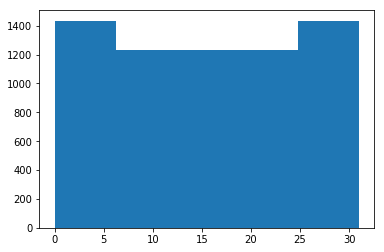

In [406]:
plt.hist(np.where(dists < q_r)[0], bins=5)

In [410]:
batch[np.where(dists < q_r)] = 0

(array([205.,   0.,   0.,   0.,   0.,   0.,  71., 591., 590., 591.]),
 array([0.        , 0.0204509 , 0.0409018 , 0.0613527 , 0.08180361,
        0.10225451, 0.12270541, 0.14315631, 0.16360721, 0.18405811,
        0.20450901]),
 <a list of 10 Patch objects>)

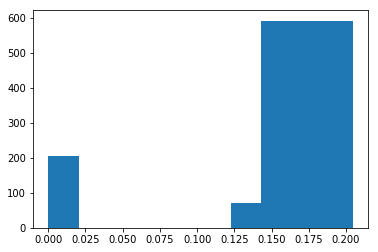

In [411]:
plt.hist(np.linalg.norm(batch[2],axis=1))

In [419]:
batch = np.reshape(np.arange(3*2048*32, dtype=np.float32), newshape=(32, 2048, 3))

In [420]:
batch = batch / np.max(batch) * 2 - 1

In [424]:
indices = np.random.choice(np.arange(batch.shape[1]), replace=False,
                               size=int(batch.shape[1] * 0.1))

In [429]:
indices.size

204

In [428]:
batch[:, indices] = np.random.uniform(size=(32, 204, 3))